In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

In [3]:
df = pd.read_parquet('/content/drive/MyDrive/NLP News Bias Data/data_newsbias_cleaned.parquet')
df = df.dropna(subset=['text', 'bias_label']).copy()
df['bias_label'] = df['bias_label'].astype(str)

In [4]:
df = (
    df.groupby('bias_label', group_keys=False)
      .apply(lambda g: g.sample(50_000, random_state=42))
      .reset_index(drop=True)
)

<ipython-input-4-837d0f7923be>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(50_000, random_state=42))


In [ ]:
#!pip install tensorflow

In [6]:
df.drop(columns=["title", "source"], inplace=True)

Create Sequences and use padding for same length

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_len = 512
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])

sequences = tokenizer.texts_to_sequences(df['text'])

# add padding to the sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='pre', truncating='post')

download word2vec embedding

In [ ]:
import gensim.downloader as api

word2vec = api.load("word2vec-google-news-300")  # pretrained vectors

In [ ]:
embedding_dim = 300  # Word2Vec GoogleNews uses 300D vectors
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]
    # else: remains zero

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode string labels to integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['bias_label'])

# Optional: save the class names
class_names = label_encoder.classes_

# Confirm encoding
print("Encoded labels:", np.unique(labels))
print("Class names:", class_names)

import the presaved label encoder, tokenizer, padded sequences and embedding matrix

In [ ]:
import pickle
import numpy as np

folder_path = "/content/drive/MyDrive/NLP News Bias Data/BiLSTM/"

# Load Pickle files
with open(folder_path + "label_classes.pkl", "rb") as f:
    label_classes = pickle.load(f)

with open(folder_path + "label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

with open(folder_path + "tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Load NumPy arrays
labels = np.load(folder_path + "labels.npy")
padded_sequences = np.load(folder_path + "padded_sequences.npy")
embedding_matrix = np.load(folder_path + "embedding_matrix.npy")

In [ ]:
# convert word indices to word vectors
from tensorflow.keras.layers import Embedding

max_len = 512

vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embedding_dim = 300  # common choice, can try 50 or 300 too

embedding_baseline = Embedding(input_dim=vocab_size,    # size of vocabulary
                               output_dim=embedding_dim,# embedding dimension
                               input_length=max_len)        # max_len from earlier (109)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# baseline Word2Vec (frozen)
embedding_word2vec_static = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_len,
    trainable=False
)

# fine-tuned Word2Vec
embedding_word2vec_trainable = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_len,
    trainable=True  # allow gradient updates
)

Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42, stratify=labels
)

Train the Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    LSTM, Dense, Bidirectional, GaussianNoise, BatchNormalization, Dropout
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def model_bilstm_trainable_optimized(
    embedding_layer,
    lstm_units=32,
    dense_units=64,
    dropout=0.5,
    l2_reg=0.001,
    learning_rate=0.001
):
    model = Sequential()
    model.add(embedding_layer)
    model.add(GaussianNoise(0.1))
    model.add(BatchNormalization())

    # BiLSTM with separate dropout and recurrent dropout
    model.add(Bidirectional(
        LSTM(lstm_units, dropout=dropout)
    ))

    if dense_units > 0:
        model.add(Dense(
            dense_units,
            activation='selu',
            kernel_regularizer=l2(l2_reg) if l2_reg else None
        ))

    # Output layer for 3-class classification
    model.add(Dense(3, activation='softmax'))

    # Adam optimizer with custom learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

define early stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

overwrite the fucntion with optimized hyperparamters

In [ ]:
model1 = model_bilstm_trainable_optimized(
    embedding_layer=embedding_word2vec_static,
    dropout=0.5,
    lstm_units=32,
    dense_units=32,
    l2_reg=0.01
)

history1 = model1.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 128s 42ms/step - accuracy: 0.4113 - loss: 1.1986 - val_accuracy: 0.4561 - val_loss: 1.0537
Epoch 2/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 124s 41ms/step - accuracy: 0.4683 - loss: 1.0360 - val_accuracy: 0.4883 - val_loss: 1.0165
Epoch 3/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 123s 41ms/step - accuracy: 0.5011 - loss: 1.0040 - val_accuracy: 0.5170 - val_loss: 0.9835
Epoch 4/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 122s 41ms/step - accuracy: 0.5146 - loss: 0.9905 - val_accuracy: 0.5215 - val_loss: 0.9843
Epoch 5/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 123s 41ms/step - accuracy: 0.5173 - loss: 0.9852 - val_accuracy: 0.5322 - val_loss: 0.9671
Epoch 6/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 123s 41ms/step - accuracy: 0.5251 - loss: 0.9775 - val_accuracy: 0.5297 - val_loss: 0.9721
Epoch 7/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 123s 41ms/step - accuracy: 0.5270 - loss: 0.9723 - val_accuracy: 0.5321 - val_loss: 0.9624
Epoch 8/30
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 122s 41ms/step - accuracy: 

evaluate optimized BiLSTM

In [ ]:
import matplotlib.pyplot as plt
def plot_individual_loss(history, label):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label=f'{label} - Train')
    plt.plot(history.history['val_loss'], linestyle='--', label=f'{label} - Val')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Training vs. Validation Loss — {label}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

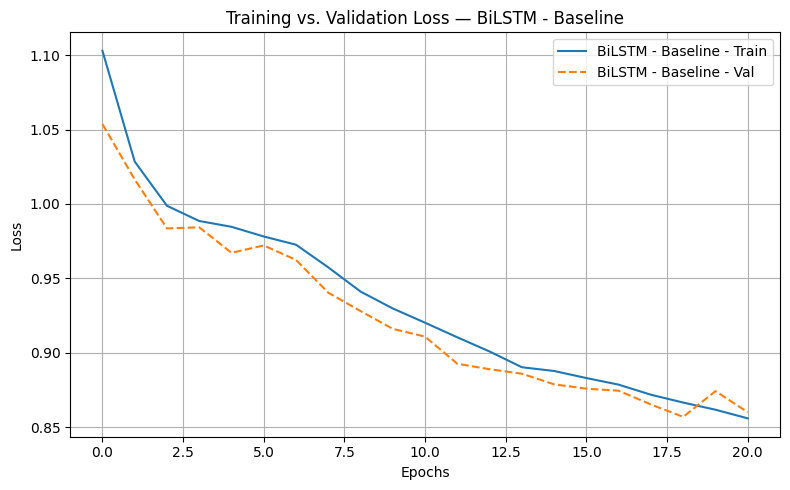

In [ ]:
plot_individual_loss(history1, "BiLSTM - Baseline")

Test

In [ ]:
from tensorflow.keras.models import load_model

# Load the model (adjust path if needed)
BiLSTM = load_model("/content/drive/MyDrive/NLP News Bias Data/BiLSTM/BiLSTM_baseline.keras")

In [ ]:
# Predict probabilities
y_pred = BiLSTM.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluate
from sklearn.metrics import classification_report

# Print report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

from sklearn.metrics import accuracy_score
print("Test Accuracy:", accuracy_score(y_test, y_pred_classes))

938/938 ━━━━━━━━━━━━━━━━━━━━ 60s 63ms/step
              precision    recall  f1-score   support

      center       0.59      0.69      0.64     10000
        left       0.64      0.63      0.64     10000
       right       0.67      0.57      0.61     10000

    accuracy                           0.63     30000
   macro avg       0.63      0.63      0.63     30000
weighted avg       0.63      0.63      0.63     30000

Test Accuracy: 0.6307


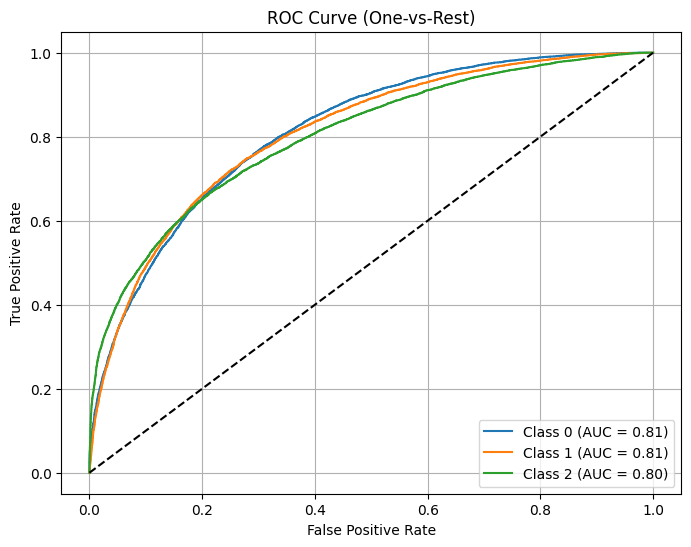

In [ ]:
# ---------- Au RoC Curve ----------

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Binarize the test labels (e.g., for 3 classes)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Plot ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

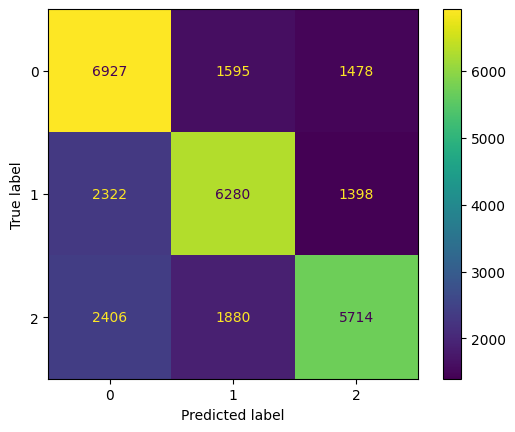

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)